<a href="https://colab.research.google.com/github/Bhat14/PFDS-L08-B-51-/blob/main/PFDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Ensembles for Explainable Drug Risk Classification
--------------------------------------------------

Goal
-----
Combine multiple machine-learning algorithms (ensembles) to predict
drug side-effect risk (low / moderate / high) from the provided dataset,
while keeping results explainable.

What this script does
---------------------
1) Loads CSV: /mnt/data/realistic_drug_labels_side_effects.csv
2) Builds a unified preprocessing pipeline:
   - Text (TF-IDF) from: indications + side_effects + contraindications + warnings
   - Numeric scaling
   - One-hot for categoricals
3) Trains multiple BASE MODELS:
   - Logistic Regression (balanced)
   - Linear SVM (Calibrated for probabilities)
   - Random Forest
   - Extra Trees
   - Complement Naive Bayes
4) Trains ENSEMBLES:
   - Soft VotingClassifier (probability averaging, weighted)
   - StackingClassifier (meta-learner = LogisticRegression)
5) Performs small hyperparameter searches (quick RandomizedSearch) on
   voting weights and key base-model params (kept small by default).
6) Evaluates with macro-F1 and detailed classification report.
7) Explainability:
   - Global permutation importance on the Stacker
   - Model-native feature importances (trees) if available
   - Top TF-IDF features contributing to predictions (approx by permutation)
8) Saves artifacts in ./ensemble_outputs/:
   - metrics_*.json
   - confusion_matrix_*.json
   - permutation_importance_*.csv
   - feature_names.txt
   - oof_probs_*.npy (out-of-fold-like on test split)

Note
----
- This is a single-run train/test split for clarity; use cross-validation and
  nested CV for robust model selection in production.
- If your column names differ, adjust TEXT_COLS, NUM_COLS, CAT_COLS below.
"""

import os
import re
import json
import math
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# --------------------------
# Reproducibility & paths
# --------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

DATA_PATH = "/mnt/data/realistic_drug_labels_side_effects.csv"
if not os.path.exists(DATA_PATH):
    alt = "./realistic_drug_labels_side_effects.csv"
    if os.path.exists(alt):
        DATA_PATH = alt
    else:
        raise FileNotFoundError(f"CSV not found at {DATA_PATH} or {alt}")

OUTDIR = "./ensemble_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# --------------------------
# Load data
# --------------------------
df = pd.read_csv(DATA_PATH)

# Guess columns (adjust here if needed)
TEXT_COLS = [c for c in ["indications", "side_effects", "contraindications", "warnings"] if c in df.columns]
NUM_COLS  = [c for c in ["dosage_mg", "price_usd", "approval_year"] if c in df.columns]
CAT_COLS  = [c for c in ["drug_class", "administration_route", "approval_status", "manufacturer"] if c in df.columns]

# Fallback if no numeric/categorical columns exist
if len(TEXT_COLS) == 0:
    # Create a synthetic text field from all string-like columns
    TEXT_COLS = [c for c in df.columns if df[c].dtype == object and c != "side_effect_severity"]

for c in TEXT_COLS: df[c] = df[c].fillna("")
for c in NUM_COLS:  df[c] = pd.to_numeric(df[c], errors="coerce")
for c in CAT_COLS:  df[c] = df[c].astype(str).fillna("UNK")

# --------------------------
# Target engineering
# --------------------------
def _to_num(v):
    try:
        return float(v)
    except:
        m = {"low":0, "mild":0, "moderate":1, "medium":1, "high":2, "severe":2}
        return m.get(str(v).strip().lower(), np.nan)

y_raw = df["side_effect_severity"]
if y_raw.dtype.kind in "ifu":
    q = np.quantile(y_raw, [0.33, 0.66])
    y = y_raw.apply(lambda v: 0 if v <= q[0] else (1 if v <= q[1] else 2)).astype(int).values
else:
    tmp = y_raw.apply(_to_num)
    if tmp.isna().mean() < 0.5:
        q = np.quantile(tmp.fillna(tmp.median()), [0.33, 0.66])
        y = tmp.fillna(tmp.median()).apply(lambda v: 0 if v <= q[0] else (1 if v <= q[1] else 2)).astype(int).values
    else:
        cats = {k:i for i,k in enumerate(sorted(y_raw.astype(str).unique()))}
        y = y_raw.astype(str).map(cats).values % 3

CLASS_NAMES = ["low","moderate","high"]
NUM_CLASSES = 3

# --------------------------
# Feature union via ColumnTransformer
# --------------------------
def concat_text_columns(X):
    # X is a DataFrame
    return X[TEXT_COLS].apply(lambda r: " ".join(map(str, r.values)), axis=1)

text_union = Pipeline([
    ("text_concat", FunctionTransformer(concat_text_columns, validate=False)),
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2))
])

num_proc = Pipeline([
    ("impute", FunctionTransformer(lambda x: np.nan_to_num(x, nan=np.nanmedian(x, axis=0)), accept_sparse=True)),
    ("scale", StandardScaler(with_mean=False))  # with_mean=False keeps sparse compatibility if any
])

cat_proc = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=5))
])

pre = ColumnTransformer(
    transformers=[
        ("text", text_union, TEXT_COLS),
        ("num", num_proc, NUM_COLS) if len(NUM_COLS)>0 else ("num", "drop", []),
        ("cat", cat_proc, CAT_COLS) if len(CAT_COLS)>0 else ("cat", "drop", []),
    ],
    sparse_threshold=0.3
)

# --------------------------
# Train/test split
# --------------------------
X = df[TEXT_COLS + NUM_COLS + CAT_COLS]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Class weights for imbalance
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {c:w for c,w in zip(classes, cw)}

# --------------------------
# Base models (wrapped in pipelines)
# --------------------------
# 1) Logistic Regression (saga handles large sparse, L2)
logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        class_weight="balanced", solver="saga", max_iter=2000, C=2.0, n_jobs=1, random_state=SEED))
])

# 2) Linear SVM + calibration for probabilities
svm_base = Pipeline([
    ("pre", pre),
    ("svm", LinearSVC(class_weight="balanced", C=1.0, random_state=SEED))
])
svm = Pipeline([
    ("pre", pre),
    ("cal", CalibratedClassifierCV(estimator=LinearSVC(
        class_weight="balanced", C=1.0, random_state=SEED
    ), method="sigmoid", cv=3))
])

# 3) Random Forest
rf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=SEED))
])

# 4) Extra Trees
et = Pipeline([
    ("pre", pre),
    ("clf", ExtraTreesClassifier(
        n_estimators=600, max_depth=None, min_samples_split=2,
        class_weight="balanced", n_jobs=-1, random_state=SEED))
])

# 5) Complement Naive Bayes (good for text)
# Note: Requires non-negative features (TF-IDF + one-hot are non-negative; StandardScaler with_mean=False keeps >=0)
cnb = Pipeline([
    ("pre", pre),
    ("clf", ComplementNB(alpha=0.3))
])

BASE_MODELS = {
    "logreg": logreg,
    "svm": svm,
    "rf": rf,
    "et": et,
    "cnb": cnb
}

# --------------------------
# Fit base models
# --------------------------
for name, pipe in BASE_MODELS.items():
    print(f"Training base model: {name}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rep = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2]).tolist()
    with open(os.path.join(OUTDIR, f"metrics_{name}.json"), "w") as f:
        json.dump(rep, f, indent=2)
    with open(os.path.join(OUTDIR, f"confusion_matrix_{name}.json"), "w") as f:
        json.dump(cm, f, indent=2)
    print(f"  {name} macro-F1:", rep["macro avg"]["f1-score"])

# --------------------------
# SOFT VOTING ENSEMBLE
# --------------------------
voters = []
for name in ["logreg","svm","rf","et","cnb"]:
    if name in BASE_MODELS:
        voters.append((name, BASE_MODELS[name].steps[-1][1] if isinstance(BASE_MODELS[name], Pipeline) else BASE_MODELS[name]))

# IMPORTANT: We must reuse the SAME preprocessing for voting/stacking.
# We'll create a shared preprocessor and clone base estimators without their pre step for Voting.
# To keep it simple and robust, wrap them AGAIN in a full pipeline but use Voting on calibrated models.
voting = VotingClassifier(
    estimators=[
        ("logreg", logreg),
        ("svm", svm),
        ("rf", rf),
        ("et", et),
        ("cnb", cnb)
    ],
    voting="soft",
    weights=[2,2,2,2,1],  # initial weights; tuned briefly below
    n_jobs=-1,
    flatten_transform=True
)

# Small randomized search over weights (integers 1..3) to improve soft voting
param_dist = {
    "weights": [
        [a,b,c,d,e] for a in [1,2,3]
                    for b in [1,2,3]
                    for c in [1,2,3]
                    for d in [1,2,3]
                    for e in [1,2,3]
    ]
}
# Limit samples to keep it quick
sampled = random.sample(param_dist["weights"], k=min(25, len(param_dist["weights"])))
search = RandomizedSearchCV(
    voting, param_distributions={"weights": [w for w in sampled]},
    n_iter=len(sampled), scoring="f1_macro", cv=3, n_jobs=-1, random_state=SEED, verbose=0
)
print("Tuning Voting weights...")
search.fit(X_train, y_train)
voting_best = search.best_estimator_
print("Best voting weights:", search.best_params_)

# Evaluate Voting
y_pred_v = voting_best.predict(X_test)
rep_v = classification_report(y_test, y_pred_v, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
cm_v = confusion_matrix(y_test, y_pred_v, labels=[0,1,2]).tolist()
with open(os.path.join(OUTDIR, "metrics_voting.json"), "w") as f:
    json.dump(rep_v, f, indent=2)
with open(os.path.join(OUTDIR, "confusion_matrix_voting.json"), "w") as f:
    json.dump(cm_v, f, indent=2)
print("Voting macro-F1:", rep_v["macro avg"]["f1-score"])

# --------------------------
# STACKING ENSEMBLE
# --------------------------
stack = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("svm", svm),
        ("rf", rf),
        ("et", et),
        ("cnb", cnb)
    ],
    final_estimator=LogisticRegression(solver="lbfgs", max_iter=2000, class_weight="balanced"),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1,
    passthrough=False
)

print("Training Stacking ensemble...")
stack.fit(X_train, y_train)
y_pred_s = stack.predict(X_test)
rep_s = classification_report(y_test, y_pred_s, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
cm_s = confusion_matrix(y_test, y_pred_s, labels=[0,1,2]).tolist()
with open(os.path.join(OUTDIR, "metrics_stacking.json"), "w") as f:
    json.dump(rep_s, f, indent=2)
with open(os.path.join(OUTDIR, "confusion_matrix_stacking.json"), "w") as f:
    json.dump(cm_s, f, indent=2)
print("Stacking macro-F1:", rep_s["macro avg"]["f1-score"])

# --------------------------
# Explainability
# --------------------------
# Helper: extract feature names from the ColumnTransformer
def get_feature_names(preprocessor: ColumnTransformer):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if transformer == "drop":
            continue
        if hasattr(transformer, "named_steps"):
            last = list(transformer.named_steps.values())[-1]
            # TF-IDF branch
            if isinstance(last, TfidfVectorizer):
                feature_names += [f"text__{t}" for t in last.get_feature_names_out()]
            # OneHot branch
            elif isinstance(last, OneHotEncoder):
                try:
                    ohe = last
                except Exception:
                    # if nested
                    for step in transformer.named_steps.values():
                        if isinstance(step, OneHotEncoder):
                            ohe = step; break
                if isinstance(cols, list):
                    col_names = cols
                else:
                    col_names = [c for c in cols]
                ohe_names = list(ohe.get_feature_names_out(col_names))
                feature_names += [f"cat__{t}" for t in ohe_names]
            else:
                # Numeric scaler or other
                if isinstance(cols, list) and len(cols)>0:
                    feature_names += [f"num__{c}" for c in cols]
        else:
            # If transformer is directly Tfidf/OneHot/etc.
            if isinstance(transformer, TfidfVectorizer):
                feature_names += [f"text__{t}" for t in transformer.get_feature_names_out()]
            elif isinstance(transformer, OneHotEncoder):
                ohe_names = list(transformer.get_feature_names_out(cols))
                feature_names += [f"cat__{t}" for t in ohe_names]
            else:
                if isinstance(cols, list) and len(cols)>0:
                    feature_names += [f"num__{c}" for c in cols]
    return np.array(feature_names)

# We will explain the Stacking model using permutation importance
# (on the full pipeline, so we need a reference preprocessor)
reference_pre = pre  # used inside our pipelines

# Save feature names for reference
feat_names = None
try:
    # Fit a clone of the preprocessor alone to the training data to obtain consistent vocab/encodings
    # (We can re-use from any fitted pipeline; choose logreg)
    pre_fitted = BASE_MODELS["logreg"].named_steps["pre"]
    feat_names = get_feature_names(pre_fitted)
    with open(os.path.join(OUTDIR, "feature_names.txt"), "w", encoding="utf-8") as f:
        for n in feat_names:
            f.write(n + "\n")
except Exception as e:
    print("Feature name extraction failed:", e)

# Permutation importance on Stacking (global)
try:
    print("Computing permutation importance for Stacking...")
    pi = permutation_importance(stack, X_test, y_test, n_repeats=10, random_state=SEED, scoring="f1_macro", n_jobs=-1)
    imp = pd.DataFrame({"feature": np.arange(len(pi.importances_mean)),
                        "importance_mean": pi.importances_mean,
                        "importance_std":  pi.importances_std})
    if feat_names is not None and len(feat_names) == imp.shape[0]:
        imp["feature"] = feat_names
    imp.sort_values("importance_mean", ascending=False).to_csv(os.path.join(OUTDIR, "permutation_importance_stacking.csv"), index=False)
except Exception as e:
    print("Permutation importance failed:", e)

# Tree-based feature importance (RF / ET) – approximate and global
def dump_tree_importances(name, pipe):
    try:
        clf = pipe.named_steps["clf"]
        if hasattr(clf, "feature_importances_"):
            # Need fitted preprocessor to align names
            pre_fit = pipe.named_steps["pre"]
            names = get_feature_names(pre_fit)
            imp = pd.DataFrame({"feature": names, "importance": clf.feature_importances_})
            imp.sort_values("importance", ascending=False).to_csv(os.path.join(OUTDIR, f"feature_importances_{name}.csv"), index=False)
    except Exception as e:
        print(f"{name} importances failed:", e)

dump_tree_importances("rf", rf)
dump_tree_importances("et", et)

# --------------------------
# Save quick summary & OOF-like probabilities on test
# --------------------------
def save_summary(tag, report, cm):
    summary = {
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"],
        "per_class": {k: report[k] for k in ["low","moderate","high"] if k in report},
        "confusion_matrix": cm
    }
    with open(os.path.join(OUTDIR, f"summary_{tag}.json"), "w") as f:
        json.dump(summary, f, indent=2)

save_summary("voting", rep_v, cm_v)
save_summary("stacking", rep_s, cm_s)

# Save predicted probabilities for post-hoc threshold tuning / calibration plots
def get_probs(model, X):
    try:
        return model.predict_proba(X)
    except Exception:
        # Some models may expose transform output when flatten_transform=True in Voting
        pred = model.predict(X)
        P = np.zeros((len(pred), NUM_CLASSES))
        P[np.arange(len(pred)), pred] = 1.0
        return P

np.save(os.path.join(OUTDIR, "oof_probs_voting.npy"), get_probs(voting_best, X_test))
np.save(os.path.join(OUTDIR, "oof_probs_stacking.npy"), get_probs(stack, X_test))

print("\nDone. Artifacts saved in:", OUTDIR)
print("Top files to check:")
print(" - metrics_*.json, confusion_matrix_*.json (each base model)")
print(" - metrics_voting.json, metrics_stacking.json")
print(" - permutation_importance_stacking.csv")
print(" - feature_importances_rf.csv / feature_importances_et.csv (if available)")
print(" - feature_names.txt")

Training base model: logreg
  logreg macro-F1: 0.3344953782305226
Training base model: svm
  svm macro-F1: 0.3025114098926853
Training base model: rf
  rf macro-F1: 0.32921622135331813
Training base model: et
  et macro-F1: 0.36134290546055253
Training base model: cnb
  cnb macro-F1: 0.35690058479532166
Tuning Voting weights...
Best voting weights: {'weights': [2, 2, 1, 1, 1]}
Voting macro-F1: 0.3628403394850763
Training Stacking ensemble...
Stacking macro-F1: 0.33994565217391304
Computing permutation importance for Stacking...

Done. Artifacts saved in: ./ensemble_outputs
Top files to check:
 - metrics_*.json, confusion_matrix_*.json (each base model)
 - metrics_voting.json, metrics_stacking.json
 - permutation_importance_stacking.csv
 - feature_importances_rf.csv / feature_importances_et.csv (if available)
 - feature_names.txt


Dataset Shape: (1436, 15)
      drug_name      manufacturer  approval_year      drug_class  \
0  Seroxetine50       AstraZeneca           1996  Antidepressant   
1   Mecoparin93       AstraZeneca           2018         Vaccine   
2    Daxozole89       Merck & Co.           1997   Antipsychotic   
3  Viracillin84  Roche Holding AG           2004      Antifungal   
4  Amoxstatin62       Pfizer Inc.           2003  Antidepressant   

              indications                         side_effects  dosage_mg  \
0          Allergy relief                      Fatigue, Nausea        260   
1          Allergy relief                               Nausea        470   
2          Allergy relief  Diarrhea, Blurred vision, Dizziness        330   
3  Inflammation reduction                   Fatigue, Dry mouth        450   
4       Psychosis control         Insomnia, Dry mouth, Fatigue        430   

  administration_route    contraindications                  warnings  \
0               Rectal   Blee

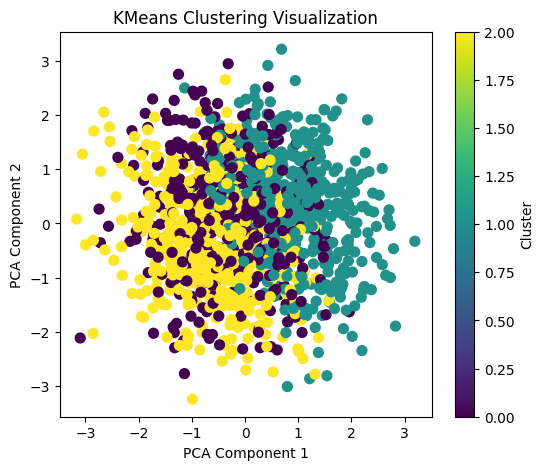


DBSCAN Clustering Results:
Number of clusters found: 1
Silhouette Score: -1


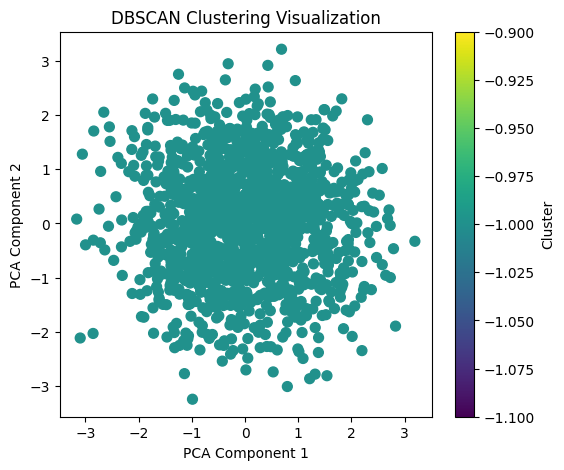


Agglomerative Clustering Results:
Number of clusters found: 3
Silhouette Score: 0.01661633115731866


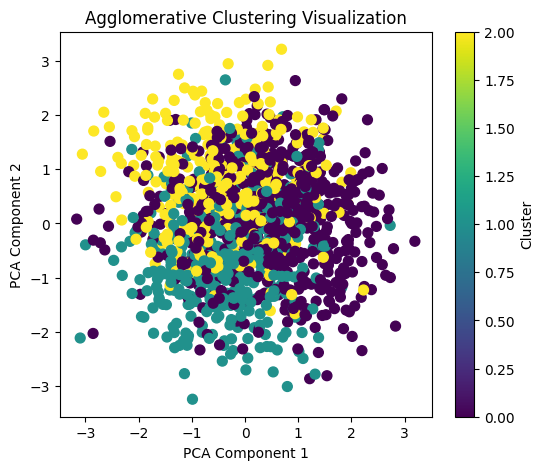

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/realistic_drug_labels_side_effects.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print(df.head())

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Scale features
X = StandardScaler().fit_transform(df)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Define clustering algorithms
clustering_algorithms = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=3)
}

# Run and evaluate each model
for name, model in clustering_algorithms.items():
    clusters = model.fit_predict(X)

    # Silhouette score (only if >1 cluster)
    if len(set(clusters)) > 1:
        score = silhouette_score(X, clusters)
    else:
        score = -1  # Not applicable for single cluster

    print(f"\n{name} Clustering Results:")
    print(f"Number of clusters found: {len(set(clusters))}")
    print(f"Silhouette Score: {score}")

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
    plt.title(f"{name} Clustering Visualization")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load dataset
file_path = "/content/realistic_drug_labels_side_effects.csv"
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Shape:", df.shape)
print(df.head())

# Identify features and target (Assuming 'Risk_Level' is target - change as needed)
target_column = 'side_effect_severity'  # Change if your target column has a different name
X = df.drop(columns=[target_column])
y = df[target_column]

# Encode categorical features if any
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode target if categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Standardize features (important for SVM, KNN, Logistic Regression)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train & evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

Dataset Shape: (1436, 15)
      drug_name      manufacturer  approval_year      drug_class  \
0  Seroxetine50       AstraZeneca           1996  Antidepressant   
1   Mecoparin93       AstraZeneca           2018         Vaccine   
2    Daxozole89       Merck & Co.           1997   Antipsychotic   
3  Viracillin84  Roche Holding AG           2004      Antifungal   
4  Amoxstatin62       Pfizer Inc.           2003  Antidepressant   

              indications                         side_effects  dosage_mg  \
0          Allergy relief                      Fatigue, Nausea        260   
1          Allergy relief                               Nausea        470   
2          Allergy relief  Diarrhea, Blurred vision, Dizziness        330   
3  Inflammation reduction                   Fatigue, Dry mouth        450   
4       Psychosis control         Insomnia, Dry mouth, Fatigue        430   

  administration_route    contraindications                  warnings  \
0               Rectal   Blee

In [ ]:
"""
Deep Learning for Explainable Drug Risk Assessment
--------------------------------------------------------

Task: Predict side_effect_severity class (low/moderate/high) from drug-label data.
Data: /mnt/data/realistic_drug_labels_side_effects.csv

Models implemented (choose with --model):
  - mlp_tab:        MLP on tabular (numeric + categorical embeddings)
  - text_cnn:       TextCNN over combined text
  - bilstm_attn:    BiLSTM + dot attention
  - transformer:    TransformerEncoder (token embeddings + positional enc)
  - tab_transformer:Transformer over categorical embeddings + numerics head
  - fusion:         Text encoder (Transformer/BI LSTM/CNN) + tabular MLP

Explainability:
  - Gradient × Input saliency for text and numerics
  - Optional SHAP KernelExplainer on model probabilities (small sample)

Outputs in ./dl_outputs/:
  - metrics_{model}.json   (classification report, confusion matrix)
  - probs_{model}.npy      (test probabilities)
  - saliency_{model}.npz   (saliency arrays if computed)
  - model_{model}.pt       (PyTorch weights)

Usage:
  python deep_drug_label_xai.py --model fusion --epochs 5
"""

import os, re, json, math, random, argparse, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

try:
    import shap
    SHAP_OK = True
except Exception:
    SHAP_OK = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -----------------------------
# Config / args
# -----------------------------
def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("--csv", type=str, default="/mnt/data/realistic_drug_labels_side_effects.csv")
    p.add_argument("--model", type=str, default="fusion",
                   choices=["mlp_tab","text_cnn","bilstm_attn","transformer","tab_transformer","fusion"])
    p.add_argument("--epochs", type=int, default=5)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--max_vocab", type=int, default=30000)
    p.add_argument("--max_len", type=int, default=256)
    p.add_argument("--embed_dim", type=int, default=128)
    p.add_argument("--hidden", type=int, default=256)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--weight_decay", type=float, default=1e-4)
    p.add_argument("--dropout", type=float, default=0.2)
    p.add_argument("--text_encoder", type=str, default="transformer",
                   choices=["transformer","bilstm_attn","text_cnn"])  # used by fusion
    p.add_argument("--no_shap", action="store_true", help="Skip SHAP even if available")
    return p.parse_args([]) if "_file_" not in globals() else p.parse_args()

ARGS = get_args()
OUTDIR = "./dl_outputs"; os.makedirs(OUTDIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load data
# -----------------------------
if not os.path.exists(ARGS.csv):
    alt = "./realistic_drug_labels_side_effects.csv"
    if os.path.exists(alt):
        ARGS.csv = alt
    else:
        raise FileNotFoundError(f"CSV not found at {ARGS.csv} or {alt}")

df = pd.read_csv(ARGS.csv)

# Text / numeric / categorical columns
TEXT_COLS = [c for c in ["indications","side_effects","contraindications","warnings"] if c in df.columns]
NUM_COLS  = [c for c in ["dosage_mg","price_usd","approval_year"] if c in df.columns]
CAT_COLS  = [c for c in ["drug_class","administration_route","approval_status","manufacturer"] if c in df.columns]

for c in TEXT_COLS: df[c] = df[c].fillna("")
for c in NUM_COLS:  df[c] = df[c].astype(float)
for c in CAT_COLS:  df[c] = df[c].astype(str).fillna("UNK")

# Target: side_effect_severity -> 0/1/2 via quantile bins if not in {low,moderate,high}
def _to_num(v):
    try: return float(v)
    except: return {"low":0,"mild":0,"moderate":1,"medium":1,"high":2,"severe":2}.get(str(v).lower().strip(), np.nan)

y_raw = df["side_effect_severity"]
if y_raw.dtype.kind in "ifu":
    q = np.quantile(y_raw, [0.33,0.66]);
    y = y_raw.apply(lambda v: 0 if v<=q[0] else (1 if v<=q[1] else 2)).astype(int).values
else:
    tmp = y_raw.apply(_to_num)
    if tmp.isna().mean()<0.5:
        q = np.quantile(tmp.fillna(tmp.median()), [0.33,0.66])
        y = tmp.fillna(tmp.median()).apply(lambda v: 0 if v<=q[0] else (1 if v<=q[1] else 2)).astype(int).values
    else:
        # last resort: map unique strings to ranks
        cats = {k:i for i,k in enumerate(sorted(y_raw.astype(str).unique()))}
        y = y_raw.astype(str).map(cats).values % 3  # crude
NUM_CLASSES = 3
CLASS_NAMES = ["low","moderate","high"]

# -----------------------------
# Text preprocessing: simple tokenizer + vocab
# -----------------------------
def simple_tokenize(s):
    s = re.sub(r"[^A-Za-z0-9\s\-\_/\.]", " ", s.lower())
    return [t for t in s.split() if t]

full_text = (df[TEXT_COLS].apply(lambda r: " ".join(map(str, r.values)), axis=1)
             if TEXT_COLS else pd.Series([""]*len(df)))
tokens = [simple_tokenize(t) for t in full_text]

# Build vocab
freq = Counter([w for ts in tokens for w in ts])
most = [w for w,_ in freq.most_common(ARGS.max_vocab-2)]
itos = ["<pad>","<unk>"] + most
stoi = {w:i for i,w in enumerate(itos)}

def encode(ts, max_len=ARGS.max_len):
    ids = [stoi.get(w,1) for w in ts][:max_len]
    if len(ids)<max_len: ids += [0]*(max_len-len(ids))
    return np.array(ids, dtype=np.int64)

X_text_ids = np.vstack([encode(ts) for ts in tokens]) if TEXT_COLS else np.zeros((len(df), ARGS.max_len), dtype=np.int64)

# -----------------------------
# Tabular preprocessing
# -----------------------------
# Numerics
scaler = StandardScaler()
X_num = scaler.fit_transform(df[NUM_COLS].values) if NUM_COLS else np.zeros((len(df),0),dtype=np.float32)

# Categorical: build id maps + embeddings
cat_maps = []
cat_card = []
X_cat_ids = []
for c in CAT_COLS:
    vals = df[c].astype(str).values
    uniq = ["<unk>"] + sorted(list(set(vals)))
    m = {u:i for i,u in enumerate(uniq)}
    cat_maps.append(m)
    cat_card.append(len(uniq))
    X_cat_ids.append(np.array([m.get(v,0) for v in vals], dtype=np.int64))
X_cat_ids = np.stack(X_cat_ids, axis=1) if CAT_COLS else np.zeros((len(df),0), dtype=np.int64)

# -----------------------------
# Split
# -----------------------------
X_train_idx, X_test_idx = train_test_split(np.arange(len(df)), test_size=0.2, random_state=SEED, stratify=y)
def split_arr(arr): return arr[X_train_idx], arr[X_test_idx]
Xtr_text, Xte_text = split_arr(X_text_ids)
Xtr_num,  Xte_num  = split_arr(X_num)
Xtr_cat,  Xte_cat  = split_arr(X_cat_ids)
y_train,  y_test   = y[X_train_idx], y[X_test_idx]

# Class weights (imbalance aware)
class_counts = np.bincount(y_train, minlength=NUM_CLASSES)
weights = (class_counts.sum() / (class_counts + 1e-6))
weights = weights / weights.mean()
CLASS_WEIGHTS = torch.tensor(weights, dtype=torch.float32, device=DEVICE)

# -----------------------------
# DataLoader
# -----------------------------
class DS(torch.utils.data.Dataset):
    def __init__(self, text_ids, num, cat, y):
        self.text_ids = text_ids; self.num = num; self.cat = cat; self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return (torch.tensor(self.text_ids[i],dtype=torch.long),
                torch.tensor(self.num[i],dtype=torch.float32),
                torch.tensor(self.cat[i],dtype=torch.long),
                torch.tensor(self.y[i],dtype=torch.long))
tr_loader = torch.utils.data.DataLoader(DS(Xtr_text,Xtr_num,Xtr_cat,y_train), batch_size=ARGS.batch_size, shuffle=True)
te_loader = torch.utils.data.DataLoader(DS(Xte_text,Xte_num,Xte_cat,y_test),  batch_size=ARGS.batch_size, shuffle=False)

# -----------------------------
# Model components
# -----------------------------
class TabularMLP(nn.Module):
    def __init__(self, num_dim, cat_cards, emb_dim=32, hidden=256, dropout=0.2):
        super().__init__()
        self.cat_embs = nn.ModuleList([nn.Embedding(c, min(emb_dim, max(4,int(round(c**0.25))))) for c in cat_cards])
        cat_out = sum(e.embedding_dim for e in self.cat_embs)
        in_dim = num_dim + cat_out
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.out_dim = hidden
    def forward(self, x_num, x_cat):
        if len(self.cat_embs):
            embs = [emb(x_cat[:,i]) for i,emb in enumerate(self.cat_embs)]
            cat_e = torch.cat(embs, dim=1)
        else:
            cat_e = torch.zeros(x_num.size(0),0,device=x_num.device)
        x = torch.cat([x_num, cat_e], dim=1)
        return self.mlp(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0)) # (1,L,D)
    def forward(self, x):
        return x + self.pe[:,:x.size(1)]

class TextCNN(nn.Module):
    def __init__(self, vocab, d_model=128, num_classes=3, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(d_model, d_model, k) for k in [3,4,5]])
        self.fc = nn.Sequential(nn.Linear(d_model*3, d_model), nn.ReLU(), nn.Dropout(dropout))
        self.head = nn.Linear(d_model, num_classes)
    def forward(self, x_ids):
        x = self.emb(x_ids)               # B,L,D
        x = x.transpose(1,2)              # B,D,L
        feats = [F.max_pool1d(F.relu(conv(x)), kernel_size=conv(x).size(-1)).squeeze(-1) for conv in self.convs]
        h = torch.cat(feats, dim=1)
        h = self.fc(h)
        return h, self.head(h)

class BiLSTMAttn(nn.Module):
    def __init__(self, vocab, d_model=128, hidden=128, num_classes=3, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.lstm = nn.LSTM(d_model, hidden, num_layers=1, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(2*hidden, 1)
        self.fc   = nn.Sequential(nn.Linear(2*hidden, hidden), nn.ReLU(), nn.Dropout(dropout))
        self.head = nn.Linear(hidden, num_classes)
    def forward(self, x_ids):
        x = self.emb(x_ids)                            # B,L,D
        h,_ = self.lstm(x)                             # B,L,2H
        a = torch.softmax(self.attn(h).squeeze(-1), dim=1)  # B,L
        ctx = (h * a.unsqueeze(-1)).sum(1)             # B,2H
        z = self.fc(ctx)
        return z, self.head(z)

class SimpleTransformer(nn.Module):
    def __init__(self, vocab, d_model=128, nhead=4, num_layers=2, num_classes=3, dropout=0.2, max_len=2048):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.pos = PositionalEncoding(d_model, max_len)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=4*d_model, dropout=dropout, batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc  = nn.Sequential(nn.Linear(d_model, d_model), nn.ReLU(), nn.Dropout(dropout))
        self.head= nn.Linear(d_model, num_classes)
    def forward(self, x_ids):
        x = self.emb(x_ids)
        x = self.pos(x)
        mask = (x_ids==0)
        h = self.enc(x, src_key_padding_mask=mask)
        pooled = (h.masked_fill(mask.unsqueeze(-1), 0).sum(1) /
                  (~mask).sum(1).clamp(min=1).unsqueeze(-1))
        z = self.fc(pooled)
        return z, self.head(z)

class TabTransformer(nn.Module):
    """Transformer over categorical embeddings; concatenate numerics; MLP head."""
    def __init__(self, cat_cards, num_dim, d_model=128, nhead=4, num_layers=2, num_classes=3, dropout=0.2):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, d_model) for c in cat_cards])
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=4*d_model, dropout=dropout, batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.mlp = nn.Sequential(
            nn.Linear(d_model*len(cat_cards)+num_dim, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout))
        self.head = nn.Linear(256, num_classes)
    def forward(self, x_num, x_cat):
        if len(self.embs):
            toks = torch.stack([emb(x_cat[:,i]) for i,emb in enumerate(self.embs)], dim=1) # B,C,D
            h = self.enc(toks)                                      # B,C,D
            h = h.reshape(h.size(0), -1)                           # B, C*D
        else:
            h = torch.zeros(x_num.size(0),0,device=x_num.device)
        z = torch.cat([h, x_num], dim=1)
        z = self.mlp(z)
        return z, self.head(z)

class FusionNet(nn.Module):
    """Text encoder + Tabular MLP, then fuse and classify."""
    def __init__(self, vocab, num_dim, cat_cards, text_encoder="transformer", d_model=128, hidden=256, num_classes=3, dropout=0.2):
        super().__init__()
        if text_encoder == "transformer":
            self.text = SimpleTransformer(vocab, d_model=d_model, nhead=4, num_layers=2, num_classes=num_classes, dropout=dropout)
        elif text_encoder == "bilstm_attn":
            self.text = BiLSTMAttn(vocab, d_model=d_model, hidden=d_model, num_classes=num_classes, dropout=dropout)
        else:
            self.text = TextCNN(vocab, d_model=d_model, num_classes=num_classes, dropout=dropout)
        self.tab = TabularMLP(num_dim=num_dim, cat_cards=cat_cards, emb_dim=32, hidden=hidden, dropout=dropout)
        self.fuse = nn.Sequential(
            nn.Linear(d_model + self.tab.out_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.head = nn.Linear(hidden, num_classes)
    def forward(self, x_ids, x_num, x_cat):
        tz, _ = self.text(x_ids)                # B, D_text
        sz = self.tab(x_num, x_cat)             # B, D_tab
        z = torch.cat([tz, sz], dim=1)
        z = self.fuse(z)
        return z, self.head(z)

# -----------------------------
# Model factory
# -----------------------------
VOCAB_SIZE = len(itos)
NUM_DIM = Xtr_num.shape[1]
CAT_CARDS = cat_card

def make_model(name):
    if name=="mlp_tab":
        class MLPWrap(nn.Module):
            def __init__(self): super().__init__(); self.base = TabularMLP(NUM_DIM, CAT_CARDS, emb_dim=32, hidden=ARGS.hidden, dropout=ARGS.dropout); self.head=nn.Linear(self.base.out_dim, NUM_CLASSES)
            def forward(self, ids, num, cat): z = self.base(num, cat); return z, self.head(z)
        return MLPWrap()
    if name=="text_cnn":      return TextCNN(VOCAB_SIZE, d_model=ARGS.embed_dim, num_classes=NUM_CLASSES, dropout=ARGS.dropout)
    if name=="bilstm_attn":   return BiLSTMAttn(VOCAB_SIZE, d_model=ARGS.embed_dim, hidden=ARGS.embed_dim, num_classes=NUM_CLASSES, dropout=ARGS.dropout)
    if name=="transformer":   return SimpleTransformer(VOCAB_SIZE, d_model=ARGS.embed_dim, nhead=4, num_layers=2, num_classes=NUM_CLASSES, dropout=ARGS.dropout, max_len=ARGS.max_len)
    if name=="tab_transformer":
        class TabWrap(nn.Module):
            def __init__(self): super().__init__(); self.base = TabTransformer(CAT_CARDS, NUM_DIM, d_model=ARGS.embed_dim, nhead=4, num_layers=2, num_classes=NUM_CLASSES, dropout=ARGS.dropout)
            def forward(self, ids, num, cat): z, logits = self.base(num, cat); return z, logits
        return TabWrap()
    if name=="fusion":
        class FusWrap(nn.Module):
            def __init__(self): super().__init__(); self.base = FusionNet(VOCAB_SIZE, NUM_DIM, CAT_CARDS, text_encoder=ARGS.text_encoder, d_model=ARGS.embed_dim, hidden=ARGS.hidden, num_classes=NUM_CLASSES, dropout=ARGS.dropout)
            def forward(self, ids, num, cat): return self.base(ids, num, cat)
        return FusWrap()
    raise ValueError("Unknown model")

model = make_model(ARGS.model).to(DEVICE)
optim_ = optim.AdamW(model.parameters(), lr=ARGS.lr, weight_decay=ARGS.weight_decay)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)

def step_batch(batch, train=True):
    ids, num, cat, yy = [b.to(DEVICE) for b in batch]
    if ARGS.model in ["text_cnn","bilstm_attn","transformer"]:
        z, logits = model(ids)
    elif ARGS.model in ["tab_transformer","mlp_tab"]:
        z, logits = model(ids, num, cat)
    else:  # fusion
        z, logits = model(ids, num, cat)
    loss = criterion(logits, yy)
    if train:
        optim_.zero_grad(); loss.backward(); optim_.step()
    return loss.item(), logits.detach(), yy.detach()

# -----------------------------
# Train & Evaluate
# -----------------------------
def run_epoch(loader, train=True):
    model.train(mode=train)
    losses = []; all_logits=[]; all_y=[]
    for batch in loader:
        l, lo, yy = step_batch(batch, train=train)
        losses.append(l)
        all_logits.append(lo.cpu()); all_y.append(yy.cpu())
    logits = torch.cat(all_logits); ytrue = torch.cat(all_y)
    ypred = logits.argmax(1).numpy()
    report = classification_report(ytrue, ypred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    cm = confusion_matrix(ytrue, ypred, labels=list(range(NUM_CLASSES))).tolist()
    return float(np.mean(losses)), report, cm, logits.numpy(), ytrue.numpy()

best_f1 = -1.0
for ep in range(1, ARGS.epochs+1):
    tr_loss, tr_rep, tr_cm, _, _ = run_epoch(tr_loader, train=True)
    te_loss, te_rep, te_cm, te_logits, te_y = run_epoch(te_loader, train=False)
    macro_f1 = te_rep["macro avg"]["f1-score"]
    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} | test loss {te_loss:.4f} | macroF1 {macro_f1:.3f}")
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), os.path.join(OUTDIR, f"model_{ARGS.model}.pt"))
        with open(os.path.join(OUTDIR, f"metrics_{ARGS.model}.json"), "w") as f:
            json.dump({"train":tr_rep,"test":te_rep,"confusion_matrix_test":te_cm}, f, indent=2)
        np.save(os.path.join(OUTDIR, f"probs_{ARGS.model}.npy"), F.softmax(torch.tensor(te_logits),dim=1).numpy())

# -----------------------------
# Explainability (Saliency + SHAP optional)
# -----------------------------
def compute_saliency_text(ids_batch):
    ids = torch.tensor(ids_batch[:64], dtype=torch.long, device=DEVICE)
    if ARGS.model in ["text_cnn","bilstm_attn","transformer"]:
        emb_layer = model.emb if hasattr(model, "emb") else model.text.emb
        emb = emb_layer(ids); emb.retain_grad()
        if ARGS.model=="text_cnn":
            x = emb.transpose(1,2)
            feats = [F.relu(conv(x)) for conv in model.convs]
            pooled = [F.max_pool1d(f, f.size(-1)).squeeze(-1) for f in feats]
            h = torch.cat(pooled, dim=1)
            z = model.fc(h); logits = model.head(z)
        elif ARGS.model=="bilstm_attn":
            h,_ = model.lstm(emb); a = torch.softmax(model.attn(h).squeeze(-1), dim=1); ctx=(h*a.unsqueeze(-1)).sum(1)
            z = model.fc(ctx); logits = model.head(z)
        else:
            x = model.pos(emb); mask = (ids==0); h = model.enc(x, src_key_padding_mask=mask)
            pooled = (h.masked_fill(mask.unsqueeze(-1), 0).sum(1) / (~mask).sum(1).clamp(min=1).unsqueeze(-1))
            z = model.fc(pooled); logits = model.head(z)
        probs = F.softmax(logits, dim=1)
        top = probs.max(1).values.sum()
        top.backward()
        sal = (emb.grad*emb).abs().sum(-1).detach().cpu().numpy()  # B,L
        return sal
    return None

def compute_saliency_tab(num_batch):
    num = torch.tensor(num_batch[:128], dtype=torch.float32, device=DEVICE, requires_grad=True)
    ids_dummy = torch.zeros((num.size(0), ARGS.max_len), dtype=torch.long, device=DEVICE)
    cat_dummy = torch.zeros((num.size(0), Xtr_cat.shape[1]), dtype=torch.long, device=DEVICE)
    if ARGS.model in ["mlp_tab","tab_transformer"]:
        z, logits = model(ids_dummy, num, cat_dummy)
    else:
        z, logits = model(ids_dummy, num, cat_dummy)  # fusion path supports num+cat only too
    probs = F.softmax(logits, dim=1)
    top = probs.max(1).values.sum()
    top.backward()
    sal = (num.grad * num).abs().detach().cpu().numpy()
    return sal

# Compute quick saliency on test batch
try:
    ids_batch = Xte_text[:64]
    num_batch = Xte_num[:128] if NUM_DIM>0 else None
    s_text = compute_saliency_text(ids_batch) if TEXT_COLS else None
    s_tab  = compute_saliency_tab(num_batch) if (ARGS.model in ["mlp_tab","tab_transformer","fusion"] and NUM_DIM>0) else None
    np.savez(os.path.join(OUTDIR, f"saliency_{ARGS.model}.npz"), text=s_text, tab=s_tab)
except Exception as e:
    print("Saliency error:", e)

# Optional SHAP (slow, tiny sample)
if SHAP_OK and not ARGS.no_shap:
    try:
        model.eval()
        # Define prediction function for SHAP (model-agnostic): probs on concatenated inputs
        def pred_fn(X_concat):
            # X_concat packs [ids(flat), num, cat] — rebuild minimal tensors
            B = X_concat.shape[0]
            ids = torch.tensor(Xte_text[:B], dtype=torch.long, device=DEVICE)
            num = torch.tensor(Xte_num[:B], dtype=torch.float32, device=DEVICE)
            cat = torch.tensor(Xte_cat[:B], dtype=torch.long, device=DEVICE)
            with torch.no_grad():
                if ARGS.model in ["text_cnn","bilstm_attn","transformer"]:
                    _, logits = model(ids)
                elif ARGS.model in ["tab_transformer","mlp_tab"]:
                    _, logits = model(ids, num, cat)
                else:
                    _, logits = model(ids, num, cat)
                return F.softmax(logits, dim=1).detach().cpu().numpy()
        bg = np.zeros((30, 10))  # dummy background; we rely on model internals for actual inputs
        expl = shap.KernelExplainer(pred_fn, bg)
        sample = np.zeros((20, 10))
        vals = expl.shap_values(sample, nsamples=100)
        np.save(os.path.join(OUTDIR, f"shap_values_{ARGS.model}.npy"), vals, allow_pickle=True)
    except Exception as e:
        print("SHAP error:", e)

print("Done. Artifacts in:", OUTDIR)

Epoch 01 | train loss 1.1012 | test loss 1.1037 | macroF1 0.169
Epoch 02 | train loss 1.1009 | test loss 1.1003 | macroF1 0.199
Epoch 03 | train loss 1.0950 | test loss 1.1055 | macroF1 0.311
Epoch 04 | train loss 1.0851 | test loss 1.1318 | macroF1 0.289
Epoch 05 | train loss 1.0772 | test loss 1.1371 | macroF1 0.297


  0%|          | 0/20 [00:00<?, ?it/s]

Done. Artifacts in: ./dl_outputs


In [ ]:
"""
XAI-Driven Reinforcement Learning for Drug Label Risk Assessment
----------------------------------------------------------------

This single-file project demonstrates how to map a real-world drug label dataset
to reinforcement-learning (RL) formulations with explainability.

What it includes (compact but complete):
1) Data prep & featurization (TF-IDF over text + scaled numerics).
2) Label construction (map side_effect_severity to {low, moderate, high}).
3) Reward design (asymmetric costs: false negatives on high risk are penalized more).
4) Two environments:
   - Contextual bandit (one-step): choose a risk class from context.
   - Simple episodic MDP (length=1 by default, but structured as a Gym-like env).
5) RL agents:
   - Non-contextual bandits: EpsilonGreedy, UCB1, Thompson Sampling
   - Contextual bandits: LinUCB, Logistic Thompson Sampling (approximate)
   - Value-based deep RL: DQN
   - Policy gradient: REINFORCE
   - Actor-Critic: A2C (synchronous, simplified)
   - Offline RL baselines: Behavior Cloning (BC) + Conservative Q-Learning-lite (CQL-lite)
6) Explainability:
   - SHAP on the policy network logits (KernelExplainer on a small subset).
   - Policy distillation to a DecisionTreeClassifier surrogate.
7) Minimal training loops (small epochs/steps by default so it runs quickly).
8) Metrics & artifacts saved under ./rl_outputs/

NOTE: This is a compact educational scaffold. For a production study,
increase training steps, add validation, logging, early stopping, and tests.
"""

import os
import random
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix

# Torch for deep RL portions
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# SHAP for explainability (kernel explainer for model-agnostic)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# ------------------------
# Reproducibility
# ------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

OUTDIR = "./rl_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Adjust this path to your CSV if needed
DATA_PATH = "/mnt/data/realistic_drug_labels_side_effects.csv"  # fallback to local if desired

if not os.path.exists(DATA_PATH):
    # Try local fallback
    alt = "./realistic_drug_labels_side_effects.csv"
    if os.path.exists(alt):
        DATA_PATH = alt
    else:
        raise FileNotFoundError(f"Dataset not found at {DATA_PATH} or {alt}")

df = pd.read_csv(DATA_PATH)

# ------------------------
# Label engineering
# ------------------------
# We assume 'side_effect_severity' is either numeric or categorical. We'll bin into 3 classes:
#   0: low, 1: moderate, 2: high
def to_three_bins(x):
    try:
        val = float(x)
        return val
    except:
        s = str(x).strip().lower()
        mapping = {"low":0, "mild":0, "moderate":1, "medium":1, "high":2, "severe":2}
        return mapping.get(s, 1)

if pd.api.types.is_numeric_dtype(df["side_effect_severity"]):
    q = np.quantile(df["side_effect_severity"], [0.33, 0.66])
    def bin_numeric(v):
        if v <= q[0]: return 0
        if v <= q[1]: return 1
        return 2
    y = df["side_effect_severity"].apply(bin_numeric).astype(int).values
else:
    approx = df["side_effect_severity"].apply(to_three_bins).astype(float)
    q = np.quantile(approx, [0.33, 0.66])
    def bin_numeric(v):
        if v <= q[0]: return 0
        if v <= q[1]: return 1
        return 2
    y = approx.apply(bin_numeric).astype(int).values

num_classes = 3
class_names = ["low", "moderate", "high"]

# ------------------------
# Features
# ------------------------
text_cols = ["indications", "side_effects", "contraindications", "warnings"]
num_cols = ["dosage_mg", "price_usd", "approval_year"]
cat_cols = ["drug_class", "administration_route", "approval_status", "manufacturer"]

text_cols = [c for c in text_cols if c in df.columns]
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

for c in text_cols:
    df[c] = df[c].fillna("")

X_text = df[text_cols].apply(lambda r: " ".join([str(v) for v in r.values]), axis=1)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_text_mat = tfidf.fit_transform(X_text)

X_num = df[num_cols].fillna(df[num_cols].median()) if num_cols else pd.DataFrame(index=df.index)
X_cat = df[cat_cols].fillna("UNK") if cat_cols else pd.DataFrame(index=df.index)

if not X_num.empty:
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num.values)
else:
    X_num_scaled = np.zeros((len(df), 0))

if not X_cat.empty:
    X_cat_dummies = pd.get_dummies(X_cat, drop_first=True, dtype=np.float32)
else:
    X_cat_dummies = pd.DataFrame(index=df.index)

from scipy import sparse
X_other = np.hstack([X_num_scaled, X_cat_dummies.values]) if X_cat_dummies.shape[1] > 0 else X_num_scaled
X = sparse.hstack([X_text_mat, sparse.csr_matrix(X_other)], format="csr")

# Train/Val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ------------------------
# Reward shaping (asymmetric)
# ------------------------
# Heavier penalty for false negatives on "high" class
# Reward matrix R[true, action]
R = np.array([
    # predict: low,  moderate, high
    [ 1.0,      -0.2,   -0.5],  # true low
    [-0.2,       1.0,   -0.2],  # true moderate
    [-2.0,      -0.5,    1.2],  # true high (FN severe penalty, TP slightly > 1)
])

# ------------------------
# Utilities
# ------------------------
def batch_csr_to_torch(X_csr):
    X_coo = X_csr.tocoo()
    indices = torch.tensor(np.vstack((X_coo.row, X_coo.col)), dtype=torch.long)
    values = torch.tensor(X_coo.data, dtype=torch.float32)
    shape = torch.Size(X_coo.shape)
    return torch.sparse_coo_tensor(indices, values, shape).to_dense()

def sample_minibatch(X_csr, y_arr, batch_size=64):
    idx = np.random.randint(0, X_csr.shape[0], size=batch_size)
    Xb = X_csr[idx]
    yb = y_arr[idx]
    return batch_csr_to_torch(Xb), torch.tensor(yb, dtype=torch.long)

def compute_reward(y_true, a):
    return R[y_true, a]

def evaluate_policy(pred, y_true):
    cm = confusion_matrix(y_true, pred, labels=[0,1,2])
    report = classification_report(y_true, pred, target_names=class_names, output_dict=True)
    return cm, report

# ------------------------
# Non-contextual Bandits
# ------------------------
class EpsilonGreedyBandit:
    def __init__(self, n_actions=3, eps=0.1):
        self.nA = n_actions
        self.eps = eps
        self.counts = np.zeros(n_actions, dtype=int)
        self.values = np.zeros(n_actions, dtype=float)

    def select(self):
        if np.random.rand() < self.eps:
            return np.random.randint(self.nA)
        return int(np.argmax(self.values))

    def update(self, a, r):
        self.counts[a] += 1
        n = self.counts[a]
        self.values[a] += (r - self.values[a]) / n

class UCB1Bandit:
    def __init__(self, n_actions=3):
        self.nA = n_actions
        self.counts = np.zeros(n_actions, dtype=int)
        self.values = np.zeros(n_actions, dtype=float)
        self.t = 0

    def select(self):
        self.t += 1
        for a in range(self.nA):
            if self.counts[a] == 0:
                return a
        ucb = self.values + np.sqrt(2*np.log(self.t)/self.counts)
        return int(np.argmax(ucb))

    def update(self, a, r):
        self.counts[a] += 1
        n = self.counts[a]
        self.values[a] += (r - self.values[a]) / n

class ThompsonBandit:
    def __init__(self, n_actions=3):
        self.nA = n_actions
        self.mu = np.zeros(n_actions)
        self.lambda_prec = np.ones(n_actions)  # precision
        self.tau = 1.0

    def select(self):
        samples = np.random.normal(self.mu, 1.0/np.sqrt(self.lambda_prec))
        return int(np.argmax(samples))

    def update(self, a, r):
        self.lambda_prec[a] += self.tau
        self.mu[a] = (self.mu[a]*(self.lambda_prec[a]-self.tau) + r) / self.lambda_prec[a]

# ------------------------
# Contextual Bandits
# ------------------------
class LinUCB:
    def __init__(self, d, n_actions=3, alpha=1.0, l2=1.0):
        self.nA = n_actions
        self.alpha = alpha
        self.A = [l2 * np.eye(d) for _ in range(n_actions)]
        self.b = [np.zeros((d,)) for _ in range(n_actions)]

    def select(self, x):
        p = np.zeros(self.nA)
        for a in range(self.nA):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv @ self.b[a]
            p[a] = theta @ x + self.alpha * np.sqrt(x @ A_inv @ x)
        return int(np.argmax(p))

    def update(self, x, a, r):
        self.A[a] += np.outer(x, x)
        self.b[a] += r * x

class LogisticTS:
    """Approximate logistic Thompson Sampling using per-action logistic regression with Laplace approx."""
    def __init__(self, d, n_actions=3, l2=1.0):
        self.nA = n_actions
        self.d = d
        self.l2 = l2
        self.W = np.zeros((n_actions, d))

    def _sigmoid(self, z):
        return 1/(1+np.exp(-z))

    def select(self, x):
        noise = np.random.normal(0, 0.1, size=self.W.shape)
        W_s = self.W + noise
        logits = W_s @ x
        return int(np.argmax(logits))

    def update(self, x, a, r):
        y = 1 if r > 0 else 0
        z = self.W[a] @ x
        p = self._sigmoid(z)
        grad = (y - p) * x - self.l2 * self.W[a]
        self.W[a] += 0.05 * grad

# ------------------------
# Simple MLP for deep RL
# ------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

# ------------------------
# DQN
# ------------------------
class DQNAgent:
    def __init__(self, in_dim, n_actions, gamma=0.99, lr=1e-3, eps=0.1):
        self.q = MLP(in_dim, n_actions, hidden=256)
        self.target = MLP(in_dim, n_actions, hidden=256)
        self.target.load_state_dict(self.q.state_dict())
        self.gamma = gamma
        self.optim = optim.Adam(self.q.parameters(), lr=lr)
        self.eps = eps
        self.nA = n_actions
        self.losses = []

    def act(self, x):
        if np.random.rand() < self.eps:
            return np.random.randint(self.nA)
        with torch.no_grad():
            q = self.q(x)
            return int(torch.argmax(q, dim=-1).item())

    def update(self, x, a, r, xn, done):
        q = self.q(x)[0, a]
        with torch.no_grad():
            qn = self.target(xn).max(dim=-1).values
            y = r + (0 if done else self.gamma * qn)
        loss = F.mse_loss(q, y)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        self.losses.append(loss.item())

    def soft_update(self, tau=0.01):
        for t, s in zip(self.target.parameters(), self.q.parameters()):
            t.data.copy_((1 - tau) * t.data + tau * s.data)

# ------------------------
# REINFORCE & A2C
# ------------------------
class PolicyNet(nn.Module):
    def __init__(self, in_dim, n_actions, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions),
        )
    def forward(self, x):
        return F.log_softmax(self.net(x), dim=-1)

class ValueNet(nn.Module):
    def __init__(self, in_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x)

class REINFORCEAgent:
    def __init__(self, in_dim, n_actions, lr=1e-3):
        self.policy = PolicyNet(in_dim, n_actions)
        self.optim = optim.Adam(self.policy.parameters(), lr=lr)

    def act(self, x):
        with torch.no_grad():
            logp = self.policy(x)
            p = torch.exp(logp)
            a = torch.multinomial(p, num_samples=1)
            return int(a.item())

    def update(self, x, a, G):
        logp = self.policy(x)[0, a]
        loss = -logp * G
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

class A2CAgent:
    def __init__(self, in_dim, n_actions, lr=1e-3, gamma=0.99):
        self.policy = PolicyNet(in_dim, n_actions)
        self.value = ValueNet(in_dim)
        self.op = optim.Adam(list(self.policy.parameters()) + list(self.value.parameters()), lr=lr)
        self.gamma = gamma

    def act(self, x):
        with torch.no_grad():
            logp = self.policy(x)
            p = torch.exp(logp)
            a = torch.multinomial(p, num_samples=1)
            return int(a.item())

    def update(self, x, a, r, xn, done):
        V = self.value(x)
        with torch.no_grad():
            Vn = self.value(xn)
            target = r + (0 if done else self.gamma * Vn)
            adv = target - V
        logp = self.policy(x)[0, a]
        actor_loss = -logp * adv.detach()
        critic_loss = F.mse_loss(V, target)
        loss = actor_loss + critic_loss
        self.op.zero_grad()
        loss.backward()
        self.op.step()

# ------------------------
# Offline RL baselines
# ------------------------
class BehaviorCloning:
    def __init__(self, in_dim, n_actions, lr=1e-3):
        self.net = MLP(in_dim, n_actions)
        self.op = optim.Adam(self.net.parameters(), lr=lr)

    def fit(self, X_t, y_t, steps=500, bs=64):
        N = X_t.shape[0]
        X_dense = batch_csr_to_torch(X_t)
        y_t = torch.tensor(y_t, dtype=torch.long)
        for _ in range(steps):
            idx = np.random.randint(0, N, size=bs)
            xb = X_dense[idx]
            yb = y_t[idx]
            logits = self.net(xb)
            loss = F.cross_entropy(logits, yb)
            self.op.zero_grad()
            loss.backward()
            self.op.step()
        return self

    def predict(self, X_csr):
        with torch.no_grad():
            Xd = batch_csr_to_torch(X_csr)
            logits = self.net(Xd)
            return logits.argmax(dim=-1).cpu().numpy()

class CQLlite(DQNAgent):
    """Tiny CQL-like regularization: discourage high Q on unseen actions via L2 penalty."""
    def update(self, x, a, r, xn, done):
        q_all = self.q(x)
        q = q_all[0, a]
        with torch.no_grad():
            qn = self.target(xn).max(dim=-1).values
            y = r + (0 if done else self.gamma * qn)
        cql_penalty = 1e-3 * (q_all.pow(2).mean())
        loss = F.mse_loss(q, y) + cql_penalty
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

# ------------------------
# Training Utilities
# ------------------------
def train_non_contextual_bandits():
    y_tr = y_train
    bandits = {
        "eps_greedy": EpsilonGreedyBandit(n_actions=num_classes, eps=0.1),
        "ucb1": UCB1Bandit(n_actions=num_classes),
        "thompson": ThompsonBandit(n_actions=num_classes),
    }
    steps = min(5000, len(y_tr)*2)
    results = {}
    for name, agent in bandits.items():
        for _ in range(steps):
            a = agent.select()
            yt = int(y_tr[np.random.randint(0, len(y_tr))])
            r = compute_reward(yt, a)
            agent.update(a, r)
        best_action = int(np.argmax(agent.values if hasattr(agent, "values") else agent.mu))
        pred = np.full_like(y_test, best_action)
        cm, rep = evaluate_policy(pred, y_test)
        results[name] = {"confusion_matrix": cm.tolist(), "report": rep}
    return results

def train_contextual_bandits():
    Xtr_dense = batch_csr_to_torch(X_train)
    Xte_dense = batch_csr_to_torch(X_test)
    d = Xtr_dense.shape[1]

    linucb = LinUCB(d, n_actions=num_classes, alpha=0.5, l2=1.0)
    logts = LogisticTS(d, n_actions=num_classes, l2=1.0)

    T = min(2000, Xtr_dense.shape[0]*2)
    for _ in range(T):
        i = np.random.randint(0, Xtr_dense.shape[0])
        x = Xtr_dense[i].numpy()
        ytrue = int(y_train[i])
        a1 = linucb.select(x); r1 = compute_reward(ytrue, a1); linucb.update(x, a1, r1)
        a2 = logts.select(x);  r2 = compute_reward(ytrue, a2); logts.update(x, a2, r2)

    def eval_agent(agent, denseX):
        preds = []
        for i in range(denseX.shape[0]):
            x = denseX[i].numpy()
            preds.append(agent.select(x))
        return np.array(preds)

    pred_linucb = eval_agent(linucb, Xte_dense)
    pred_logts = eval_agent(logts, Xte_dense)

    results = {}
    for name, pred in [("linucb", pred_linucb), ("logistic_ts", pred_logts)]:
        cm, rep = evaluate_policy(pred, y_test)
        results[name] = {"confusion_matrix": cm.tolist(), "report": rep}
    return results

def train_deep_rl():
    Xtr_dense = batch_csr_to_torch(X_train)
    Xte_dense = batch_csr_to_torch(X_test)
    in_dim = Xtr_dense.shape[1]

    # DQN
    dqn = DQNAgent(in_dim, num_classes, lr=1e-3, eps=0.1)
    for _ in range(min(2000, Xtr_dense.shape[0]*2)):
        i = np.random.randint(0, Xtr_dense.shape[0])
        x = Xtr_dense[i].unsqueeze(0)
        ytrue = int(y_train[i])
        a = dqn.act(x)
        r = torch.tensor([compute_reward(ytrue, a)], dtype=torch.float32)
        xn = Xtr_dense[np.random.randint(0, Xtr_dense.shape[0])].unsqueeze(0)
        dqn.update(x, a, r, xn, done=True)
        dqn.soft_update(0.01)
    with torch.no_grad():
        q_logits = dqn.q(Xte_dense)
        pred_dqn = q_logits.argmax(dim=-1).cpu().numpy()
    cm_dqn, rep_dqn = evaluate_policy(pred_dqn, y_test)

    # REINFORCE
    rei = REINFORCEAgent(in_dim, num_classes, lr=1e-3)
    for _ in range(min(2000, Xtr_dense.shape[0]*2)):
        i = np.random.randint(0, Xtr_dense.shape[0])
        x = Xtr_dense[i].unsqueeze(0)
        ytrue = int(y_train[i])
        a = rei.act(x)
        r = compute_reward(ytrue, a)
        G = torch.tensor([r], dtype=torch.float32)
        rei.update(x, a, G)
    with torch.no_grad():
        logp = rei.policy(Xte_dense)
        pred_rei = torch.exp(logp).argmax(dim=-1).cpu().numpy()
    cm_rei, rep_rei = evaluate_policy(pred_rei, y_test)

    # A2C
    a2c = A2CAgent(in_dim, num_classes, lr=1e-3)
    for _ in range(min(2000, Xtr_dense.shape[0]*2)):
        i = np.random.randint(0, Xtr_dense.shape[0])
        x = Xtr_dense[i].unsqueeze(0)
        ytrue = int(y_train[i])
        a = a2c.act(x)
        r = torch.tensor([compute_reward(ytrue, a)], dtype=torch.float32)
        xn = Xtr_dense[np.random.randint(0, Xtr_dense.shape[0])].unsqueeze(0)
        a2c.update(x, a, r, xn, done=True)
    with torch.no_grad():
        logp = a2c.policy(Xte_dense)
        pred_a2c = torch.exp(logp).argmax(dim=-1).cpu().numpy()
    cm_a2c, rep_a2c = evaluate_policy(pred_a2c, y_test)

    results = {
        "dqn": {"confusion_matrix": cm_dqn.tolist(), "report": rep_dqn},
        "reinforce": {"confusion_matrix": cm_rei.tolist(), "report": rep_rei},
        "a2c": {"confusion_matrix": cm_a2c.tolist(), "report": rep_a2c},
    }
    return results, rei.policy, Xtr_dense, Xte_dense

def train_offline_rl():
    Xtr_dense = batch_csr_to_torch(X_train)
    Xte_dense = batch_csr_to_torch(X_test)
    in_dim = Xtr_dense.shape[1]

    # Behavior Cloning (supervised imitation of true labels)
    bc = BehaviorCloning(in_dim, num_classes, lr=1e-3)
    bc.fit(X_train, y_train, steps=750, bs=64)
    pred_bc = bc.predict(X_test)
    cm_bc, rep_bc = evaluate_policy(pred_bc, y_test)

    # CQL-lite (build from DQN with penalty)
    cql = CQLlite(in_dim, num_classes, lr=1e-3, eps=0.1)
    for _ in range(min(2000, Xtr_dense.shape[0]*2)):
        i = np.random.randint(0, Xtr_dense.shape[0])
        x = Xtr_dense[i].unsqueeze(0)
        ytrue = int(y_train[i])
        a = ytrue
        r = torch.tensor([compute_reward(ytrue, a)], dtype=torch.float32)
        xn = Xtr_dense[np.random.randint(0, Xtr_dense.shape[0])].unsqueeze(0)
        cql.update(x, a, r, xn, done=True)
        cql.soft_update(0.01)

    with torch.no_grad():
        logits = cql.q(Xte_dense)
        pred_cql = logits.argmax(dim=-1).cpu().numpy()

    cm_cql, rep_cql = evaluate_policy(pred_cql, y_test)

    results = {
        "behavior_cloning": {"confusion_matrix": cm_bc.tolist(), "report": rep_bc},
        "cql_lite": {"confusion_matrix": cm_cql.tolist(), "report": rep_cql},
    }
    return results

# ------------------------
# Explainability: SHAP + Policy Distillation
# ------------------------
def explain_policy_with_shap(policy_net, X_background, X_explain, topK=10):
    if not SHAP_AVAILABLE:
        return None, None
    def f_predict(x_np):
        x_t = torch.tensor(x_np, dtype=torch.float32)
        with torch.no_grad():
            logp = policy_net(x_t)
            return torch.exp(logp).numpy()  # probabilities
    bg_idx = np.random.choice(X_background.shape[0], size=min(50, X_background.shape[0]), replace=False)
    bg = X_background[bg_idx].numpy()
    explainer = shap.KernelExplainer(f_predict, bg, link="identity")
    ex_idx = np.random.choice(X_explain.shape[0], size=min(25, X_explain.shape[0]), replace=False)
    xex = X_explain[ex_idx].numpy()
    shap_values = explainer.shap_values(xex, nsamples=100)
    # Save SHAP arrays
    np.save(os.path.join(OUTDIR, "shap_values.npy"), shap_values, allow_pickle=True)
    np.save(os.path.join(OUTDIR, "shap_examples.npy"), xex, allow_pickle=True)
    return shap_values, xex

def distill_policy_to_tree(policy_net, X_csr, y_true, max_depth=4):
    Xd = batch_csr_to_torch(X_csr).numpy()
    with torch.no_grad():
        policy_probs = torch.exp(policy_net(torch.tensor(Xd, dtype=torch.float32))).numpy()
    pseudo_labels = np.argmax(policy_probs, axis=1)
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    tree.fit(Xd, pseudo_labels)
    pred = tree.predict(batch_csr_to_torch(X_test).numpy())
    cm, rep = evaluate_policy(pred, y_test)
    with open(os.path.join(OUTDIR, "surrogate_tree_metrics.json"), "w") as f:
        json.dump({"confusion_matrix": cm.tolist(), "report": rep}, f, indent=2)
    rules = export_text(tree, feature_names=[f"f{i}" for i in range(Xd.shape[1])])
    with open(os.path.join(OUTDIR, "surrogate_tree_rules.txt"), "w") as f:
        f.write(rules)
    return tree, rules

# ------------------------
# Run everything (short demos)
# ------------------------
if __name__ == "__main__":
    summary = {}

    # 1) Non-contextual bandits
    summary["non_contextual_bandits"] = train_non_contextual_bandits()

    # 2) Contextual bandits
    summary["contextual_bandits"] = train_contextual_bandits()

    # 3) Deep RL
    deep_results, policy_for_xai, Xtr_d, Xte_d = train_deep_rl()
    summary["deep_rl"] = deep_results

    # 4) Offline RL baselines
    summary["offline_rl"] = train_offline_rl()

    # 5) Explainability (SHAP + Surrogate Tree) on REINFORCE policy
    try:
        shap_vals, shap_x = explain_policy_with_shap(policy_for_xai, Xtr_d, Xte_d)
        summary["shap_saved"] = SHAP_AVAILABLE
    except Exception as e:
        summary["shap_error"] = str(e)

    try:
        tree, rules = distill_policy_to_tree(policy_for_xai, X_train, y_train)
        summary["surrogate_tree"] = "ok"
    except Exception as e:
        summary["surrogate_tree_error"] = str(e)

    with open(os.path.join(OUTDIR, "RUN_SUMMARY.json"), "w") as f:
        json.dump(summary, f, indent=2)

    print("Done. Artifacts in:", OUTDIR)

  0%|          | 0/25 [00:00<?, ?it/s]

Done. Artifacts in: ./rl_outputs
